In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import optuna
from optuna import trial as optuna_trial
from optuna.samplers import TPESampler


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [2]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(42)

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        # 데이터셋 초기화 및 전처리 작업 수행
        self.data = data
        self.transform = transform

    def __len__(self):
        # 데이터셋의 샘플 수 반환
        return len(self.data)

    def __getitem__(self, idx):
        # 인덱스(idx)에 해당하는 샘플 반환
        image = Image.open(self.data['img_path'][idx])
        label = self.data['label'][idx]

        if self.transform:
            image = self.transform(image)
        
        return image, label.item()

In [4]:
# 데이터셋과 데이터로더 설정
transform = transforms.Compose([
    # 여기에 필요한 전처리 작업을 추가합니다.
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # 다른 전처리 작업들을 추가할 수 있습니다.
])

## data augmentation시 성능이 내려감

In [5]:
# 데이터 증강을 위한 변환 정의
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),  # 랜덤 회전 (±30도)
    transforms.RandomHorizontalFlip(p=0.5),  # 랜덤 수평 뒤집기
])

In [6]:
# CSV 파일을 읽어옴
df = pd.read_csv("train.csv")

# img_path와 upscale_img_path를 기준으로 병합하여 새로운 DataFrame 생성
df_1 = df[['img_path', 'label']]
df_2 = df[['upscale_img_path', 'label']]

# 컬럼명을 일치시킴
df_1.columns = ['img_path', 'label']
df_2.columns = ['img_path', 'label']

# 데이터프레임 병합
merged_df = pd.concat([df_1, df_2])

# 결과 출력
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 31668 entries, 0 to 15833
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_path  31668 non-null  object
 1   label     31668 non-null  object
dtypes: object(2)
memory usage: 742.2+ KB


In [7]:
df = pd.read_csv('train.csv')

# 데이터를 train, validation, test로 나누기
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)

train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [8]:
# 훈련 데이터, 검증 데이터, 테스트 데이터의 레이블을 합칩니다.
all_labels = pd.concat([train_df['label'], valid_df['label'], test_df['label']])

# 중복을 제거하여 unique한 레이블을 얻습니다.
unique_labels = all_labels.drop_duplicates()

# unique_labels에 대해 인덱스를 부여하여 딕셔너리를 만듭니다.
label_to_index = {}
idx = 0

for label in unique_labels:
    label_to_index[label] = idx
    idx += 1

# 각 데이터셋의 레이블을 딕셔너리를 사용하여 매핑합니다.
train_df['label'] = train_df['label'].map(label_to_index)
valid_df['label'] = valid_df['label'].map(label_to_index)
test_df['label'] = test_df['label'].map(label_to_index)


In [9]:
train_dataset = CustomDataset(train_df, transform=transforms.Compose([transform]))
valid_dataset = CustomDataset(valid_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Optuna

In [10]:
# Define model training function
def train_model(trial: optuna_trial.Trial, learning_rate: float) -> float:
    # ViT 모델 및 전이 학습 준비
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # 손실 함수 및 최적화 기법 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 모델 학습
    epochs = 20
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)

        # 검증 데이터셋을 이용한 성능 평가
        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                valid_loss += criterion(outputs.logits, labels).item()
                _, predicted = torch.max(outputs.logits, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_valid_loss = valid_loss / len(valid_loader.dataset)

            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}/{epochs}, '
                  f'Train Loss: {epoch_train_loss:.4f}, '
                  f'Valid Loss: {epoch_valid_loss:.4f}, '
                  f'Valid Accuracy: {accuracy:.2f}%')

            # Report intermediate results to Optuna
            trial.report(epoch_valid_loss, epoch)

            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.TrialPruned()

    return epoch_valid_loss

In [11]:
# Define objective function for Optuna
def objective(trial: optuna_trial.Trial) -> float:
    # Sample hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 2.40539791121905e-05, 1.8361161694452508e-05, log=True)

    # Train model and return validation loss
    return train_model(trial, learning_rate)

In [12]:
if __name__ == "__main__":
    # Set up Optuna
    study = optuna.create_study(
        direction="minimize",
        sampler=TPESampler(seed=42),  # Use TPE sampler
    )

    # Run optimization
    study.optimize(objective, n_trials=3)

    # Get the best trial
    best_trial = study.best_trial

    # Print best hyperparameters and results
    print("Best trial:")
    print("  Value: ", best_trial.value)
    print("  Params: ")
    for key, value in best_trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-05-08 17:16:01,399] A new study created in memory with name: no-name-cdf11bc9-955b-468f-8b4c-3ecb2374a70f
/home/taeyoung3060/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 1/20, Train Loss: 2.3422, Valid Loss: 0.0078, Valid Accuracy: 89.98%
Epoch 2/20, Train Loss: 0.3166, Valid Loss: 0.0043, Valid Accuracy: 93.73%
Epoch 3/20, Train Loss: 0.1428, Valid Loss: 0.0033, Valid Accuracy: 95.07%
Epoch 4/20, Train Loss: 0.0709, Valid Loss: 0.0029, Valid Accuracy: 95.22%
Epoch 5/20, Train Loss: 0.0366, Valid Loss: 0.0028, Valid Accuracy: 95.46%
Epoch 6/20, Train Loss: 0.0184, Valid Loss: 0.0027, Valid Accuracy: 95.82%
Epoch 7/20, Train Loss: 0.0103, Valid Loss: 0.0027, Valid Accuracy: 95.86%
Epoch 8/20, Train Loss: 0.0057, Valid Loss: 0.0027, Valid Accuracy: 95.70%
Epoch 9/20, Train Loss: 0.0040, Valid Loss: 0.0026, Valid Accuracy: 95.82%
Epoch 10/20, Train Loss: 0.0026, Valid Loss: 0.0027, Valid Accuracy: 95.82%
Epoch 11/20, Train Loss: 0.0019, Valid Loss: 0.0026, Valid Accuracy: 95.90%
Epoch 12/20, Train Loss: 0.0015, Valid Loss: 0.0027, Valid Accuracy: 95.90%
Epoch 13/20, Train Loss: 0.0012, Valid Loss: 0.0027, Valid Accuracy: 95.86%
Epoch 14/20, Train Lo

[I 2024-05-08 19:51:02,189] Trial 0 finished with value: 0.0028279178714101815 and parameters: {'learning_rate': 8.94241464958811e-06}. Best is trial 0 with value: 0.0028279178714101815.


Epoch 20/20, Train Loss: 0.0003, Valid Loss: 0.0028, Valid Accuracy: 95.97%
Epoch 1/20, Train Loss: 1.0252, Valid Loss: 0.0032, Valid Accuracy: 94.87%
Epoch 2/20, Train Loss: 0.1013, Valid Loss: 0.0026, Valid Accuracy: 95.90%
Epoch 3/20, Train Loss: 0.0269, Valid Loss: 0.0021, Valid Accuracy: 96.25%
Epoch 4/20, Train Loss: 0.0101, Valid Loss: 0.0020, Valid Accuracy: 96.96%
Epoch 5/20, Train Loss: 0.0039, Valid Loss: 0.0018, Valid Accuracy: 97.00%
Epoch 6/20, Train Loss: 0.0021, Valid Loss: 0.0023, Valid Accuracy: 96.29%
Epoch 7/20, Train Loss: 0.0142, Valid Loss: 0.0023, Valid Accuracy: 96.05%
Epoch 8/20, Train Loss: 0.0111, Valid Loss: 0.0026, Valid Accuracy: 95.62%
Epoch 9/20, Train Loss: 0.0085, Valid Loss: 0.0016, Valid Accuracy: 97.04%
Epoch 10/20, Train Loss: 0.0061, Valid Loss: 0.0021, Valid Accuracy: 96.69%
Epoch 11/20, Train Loss: 0.0098, Valid Loss: 0.0020, Valid Accuracy: 96.33%
Epoch 12/20, Train Loss: 0.0063, Valid Loss: 0.0019, Valid Accuracy: 96.80%
Epoch 13/20, Train Lo

[I 2024-05-08 22:30:27,859] Trial 1 finished with value: 0.0014615214366212946 and parameters: {'learning_rate': 2.8515470704879856e-05}. Best is trial 1 with value: 0.0014615214366212946.


Epoch 20/20, Train Loss: 0.0001, Valid Loss: 0.0015, Valid Accuracy: 97.91%
Epoch 1/20, Train Loss: 1.3844, Valid Loss: 0.0041, Valid Accuracy: 94.36%
Epoch 2/20, Train Loss: 0.1452, Valid Loss: 0.0029, Valid Accuracy: 95.34%
Epoch 3/20, Train Loss: 0.0496, Valid Loss: 0.0024, Valid Accuracy: 95.74%
Epoch 4/20, Train Loss: 0.0167, Valid Loss: 0.0023, Valid Accuracy: 95.78%
Epoch 5/20, Train Loss: 0.0081, Valid Loss: 0.0022, Valid Accuracy: 96.21%
Epoch 6/20, Train Loss: 0.0036, Valid Loss: 0.0021, Valid Accuracy: 96.29%
Epoch 7/20, Train Loss: 0.0020, Valid Loss: 0.0021, Valid Accuracy: 96.41%
Epoch 8/20, Train Loss: 0.0013, Valid Loss: 0.0021, Valid Accuracy: 96.37%
Epoch 9/20, Train Loss: 0.0009, Valid Loss: 0.0021, Valid Accuracy: 96.41%
Epoch 10/20, Train Loss: 0.0007, Valid Loss: 0.0021, Valid Accuracy: 96.33%
Epoch 11/20, Train Loss: 0.0006, Valid Loss: 0.0021, Valid Accuracy: 96.37%
Epoch 12/20, Train Loss: 0.0005, Valid Loss: 0.0022, Valid Accuracy: 96.25%
Epoch 13/20, Train Lo

[I 2024-05-09 01:07:02,246] Trial 2 finished with value: 0.002299537667570946 and parameters: {'learning_rate': 1.8361161694452508e-05}. Best is trial 1 with value: 0.0014615214366212946.


Epoch 20/20, Train Loss: 0.0001, Valid Loss: 0.0023, Valid Accuracy: 96.49%


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/20, Train Loss: 1.6819, Valid Loss: 0.0051, Valid Accuracy: 92.94%
Epoch 2/20, Train Loss: 0.1913, Valid Loss: 0.0031, Valid Accuracy: 95.19%
Epoch 3/20, Train Loss: 0.0722, Valid Loss: 0.0026, Valid Accuracy: 95.74%
Epoch 4/20, Train Loss: 0.0281, Valid Loss: 0.0025, Valid Accuracy: 95.54%
Epoch 5/20, Train Loss: 0.0115, Valid Loss: 0.0024, Valid Accuracy: 96.05%
Epoch 6/20, Train Loss: 0.0055, Valid Loss: 0.0024, Valid Accuracy: 95.97%
Epoch 7/20, Train Loss: 0.0032, Valid Loss: 0.0024, Valid Accuracy: 96.29%
Epoch 8/20, Train Loss: 0.0021, Valid Loss: 0.0023, Valid Accuracy: 96.33%
Epoch 9/20, Train Loss: 0.0015, Valid Loss: 0.0023, Valid Accuracy: 96.17%
Epoch 10/20, Train Loss: 0.0011, Valid Loss: 0.0023, Valid Accuracy: 96.33%
Epoch 11/20, Train Loss: 0.0009, Valid Loss: 0.0023, Valid Accuracy: 96.29%
Epoch 12/20, Train Loss: 0.0007, Valid Loss: 0.0023, Valid Accuracy: 96.13%
Epoch 13/20, Train Loss: 0.0006, Valid Loss: 0.0023, Valid Accuracy: 96.21%
Epoch 14/20, Train Lo

[I 2024-05-09 03:45:12,652] Trial 3 finished with value: 0.002412874954804997 and parameters: {'learning_rate': 1.4039560409365693e-05}. Best is trial 1 with value: 0.0014615214366212946.


Epoch 20/20, Train Loss: 0.0001, Valid Loss: 0.0024, Valid Accuracy: 96.33%
Epoch 1/20, Train Loss: 3.1874, Valid Loss: 0.0140, Valid Accuracy: 83.46%
Epoch 2/20, Train Loss: 0.5375, Valid Loss: 0.0060, Valid Accuracy: 91.83%
Epoch 3/20, Train Loss: 0.2517, Valid Loss: 0.0043, Valid Accuracy: 93.45%
Epoch 4/20, Train Loss: 0.1466, Valid Loss: 0.0036, Valid Accuracy: 94.44%
Epoch 5/20, Train Loss: 0.0862, Valid Loss: 0.0034, Valid Accuracy: 94.63%
Epoch 6/20, Train Loss: 0.0506, Valid Loss: 0.0032, Valid Accuracy: 95.11%
Epoch 7/20, Train Loss: 0.0299, Valid Loss: 0.0030, Valid Accuracy: 95.11%
Epoch 8/20, Train Loss: 0.0182, Valid Loss: 0.0030, Valid Accuracy: 95.07%
Epoch 9/20, Train Loss: 0.0114, Valid Loss: 0.0030, Valid Accuracy: 95.07%
Epoch 10/20, Train Loss: 0.0075, Valid Loss: 0.0030, Valid Accuracy: 95.22%
Epoch 11/20, Train Loss: 0.0051, Valid Loss: 0.0031, Valid Accuracy: 95.22%
Epoch 12/20, Train Loss: 0.0037, Valid Loss: 0.0031, Valid Accuracy: 95.15%
Epoch 13/20, Train Lo

[I 2024-05-09 06:20:27,723] Trial 4 finished with value: 0.0032331978618487093 and parameters: {'learning_rate': 5.760341850783641e-06}. Best is trial 1 with value: 0.0014615214366212946.


Epoch 20/20, Train Loss: 0.0006, Valid Loss: 0.0032, Valid Accuracy: 95.46%


[I 2024-05-09 06:28:12,510] Trial 5 pruned. 


Epoch 1/20, Train Loss: 3.1904, Valid Loss: 0.0141, Valid Accuracy: 83.15%


[I 2024-05-09 06:35:57,157] Trial 6 pruned. 


Epoch 1/20, Train Loss: 3.6263, Valid Loss: 0.0191, Valid Accuracy: 77.11%
Epoch 1/20, Train Loss: 1.1392, Valid Loss: 0.0036, Valid Accuracy: 94.40%
Epoch 2/20, Train Loss: 0.1123, Valid Loss: 0.0025, Valid Accuracy: 95.46%
Epoch 3/20, Train Loss: 0.0330, Valid Loss: 0.0020, Valid Accuracy: 96.61%
Epoch 4/20, Train Loss: 0.0137, Valid Loss: 0.0020, Valid Accuracy: 96.49%
Epoch 5/20, Train Loss: 0.0049, Valid Loss: 0.0021, Valid Accuracy: 96.61%
Epoch 6/20, Train Loss: 0.0033, Valid Loss: 0.0020, Valid Accuracy: 96.57%
Epoch 7/20, Train Loss: 0.0017, Valid Loss: 0.0019, Valid Accuracy: 96.88%
Epoch 8/20, Train Loss: 0.0009, Valid Loss: 0.0018, Valid Accuracy: 97.00%
Epoch 9/20, Train Loss: 0.0006, Valid Loss: 0.0018, Valid Accuracy: 97.00%
Epoch 10/20, Train Loss: 0.0005, Valid Loss: 0.0018, Valid Accuracy: 97.00%
Epoch 11/20, Train Loss: 0.0004, Valid Loss: 0.0018, Valid Accuracy: 97.20%
Epoch 12/20, Train Loss: 0.0003, Valid Loss: 0.0018, Valid Accuracy: 97.16%
Epoch 13/20, Train Los

[I 2024-05-09 09:10:37,425] Trial 7 finished with value: 0.0019229185120928013 and parameters: {'learning_rate': 2.40539791121905e-05}. Best is trial 1 with value: 0.0014615214366212946.


Epoch 20/20, Train Loss: 0.0001, Valid Loss: 0.0019, Valid Accuracy: 97.20%


[I 2024-05-09 09:18:23,873] Trial 8 pruned. 


Epoch 1/20, Train Loss: 1.6969, Valid Loss: 0.0052, Valid Accuracy: 93.01%
Epoch 1/20, Train Loss: 1.4566, Valid Loss: 0.0042, Valid Accuracy: 94.08%
Epoch 2/20, Train Loss: 0.1544, Valid Loss: 0.0028, Valid Accuracy: 95.54%
Epoch 3/20, Train Loss: 0.0532, Valid Loss: 0.0024, Valid Accuracy: 95.94%
Epoch 4/20, Train Loss: 0.0182, Valid Loss: 0.0021, Valid Accuracy: 96.25%
Epoch 5/20, Train Loss: 0.0074, Valid Loss: 0.0022, Valid Accuracy: 96.45%
Epoch 6/20, Train Loss: 0.0035, Valid Loss: 0.0022, Valid Accuracy: 96.61%
Epoch 7/20, Train Loss: 0.0021, Valid Loss: 0.0021, Valid Accuracy: 96.53%
Epoch 8/20, Train Loss: 0.0013, Valid Loss: 0.0021, Valid Accuracy: 96.49%
Epoch 9/20, Train Loss: 0.0010, Valid Loss: 0.0022, Valid Accuracy: 96.61%
Epoch 10/20, Train Loss: 0.0008, Valid Loss: 0.0021, Valid Accuracy: 96.53%
Epoch 11/20, Train Loss: 0.0006, Valid Loss: 0.0021, Valid Accuracy: 96.61%
Epoch 12/20, Train Loss: 0.0005, Valid Loss: 0.0021, Valid Accuracy: 96.45%
Epoch 13/20, Train Los

[I 2024-05-09 11:53:45,346] Trial 9 finished with value: 0.0022804887705798987 and parameters: {'learning_rate': 1.7498097328214374e-05}. Best is trial 1 with value: 0.0014615214366212946.


Epoch 20/20, Train Loss: 0.0001, Valid Loss: 0.0023, Valid Accuracy: 96.49%
Best trial:
  Value:  0.0014615214366212946
  Params: 
    learning_rate: 2.8515470704879856e-05


In [1]:
study_df = study.trials_dataframe()
study_df

NameError: name 'study' is not defined

In [15]:
# ViT 모델 및 전이 학습 준비
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

classifier = nn.Linear(model.config.hidden_size, 25)
model.classifier = classifier

In [16]:
# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [17]:
# 손실 함수 및 최적화 기법 설정
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3.1489116479568635e-05)

In [19]:
# 모델을 저장할 디렉토리 생성
os.makedirs('saved_models', exist_ok=True)

best_accuracy = 0.0
best_model_path = 'saved_models/best_model.pth'

epochs = 10

train_losses = []
valid_losses = []
valid_accuracies = []

# 모델 학습
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # 검증 데이터셋을 이용한 성능 평가
    model.eval()
    with torch.no_grad():
        valid_loss = 0.0
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            valid_loss += criterion(outputs.logits, labels).item()
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_valid_loss = valid_loss / len(valid_loader.dataset)
        valid_losses.append(epoch_valid_loss)

        accuracy = 100 * correct / total
        valid_accuracies.append(accuracy)

        # 최고 성능 모델 저장
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), f'saved_models/best_model.pth')
            print(f'Best model saved with accuracy: {accuracy:.2f}%')

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Accuracy: {accuracy:.2f}%')

    # 최신 모델 저장
    latest_model_path = f'saved_models/latest_model.pth'
    torch.save(model.state_dict(), latest_model_path)
    print(f'Latest model saved: {latest_model_path}')


Best model saved with accuracy: 97.00%
Epoch [1/10], Train Loss: 0.5001, Valid Loss: 0.0020, Valid Accuracy: 97.00%
Latest model saved: saved_models/latest_model.pth
Best model saved with accuracy: 97.75%
Epoch [2/10], Train Loss: 0.0567, Valid Loss: 0.0014, Valid Accuracy: 97.75%
Latest model saved: saved_models/latest_model.pth
Best model saved with accuracy: 97.91%
Epoch [3/10], Train Loss: 0.0138, Valid Loss: 0.0012, Valid Accuracy: 97.91%
Latest model saved: saved_models/latest_model.pth
Best model saved with accuracy: 98.03%
Epoch [4/10], Train Loss: 0.0043, Valid Loss: 0.0012, Valid Accuracy: 98.03%
Latest model saved: saved_models/latest_model.pth
Epoch [5/10], Train Loss: 0.0022, Valid Loss: 0.0011, Valid Accuracy: 97.99%
Latest model saved: saved_models/latest_model.pth
Best model saved with accuracy: 98.11%
Epoch [6/10], Train Loss: 0.0013, Valid Loss: 0.0011, Valid Accuracy: 98.11%
Latest model saved: saved_models/latest_model.pth
Epoch [7/10], Train Loss: 0.0009, Valid Los

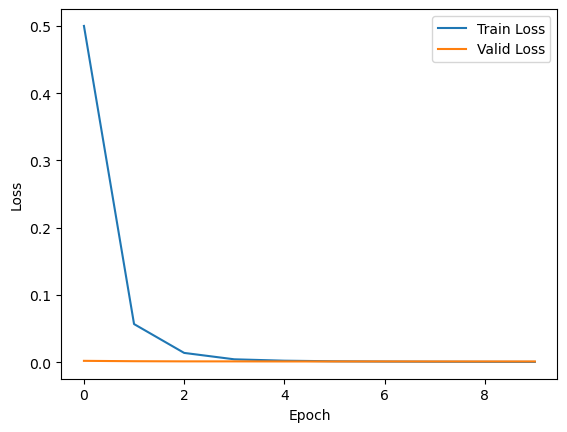

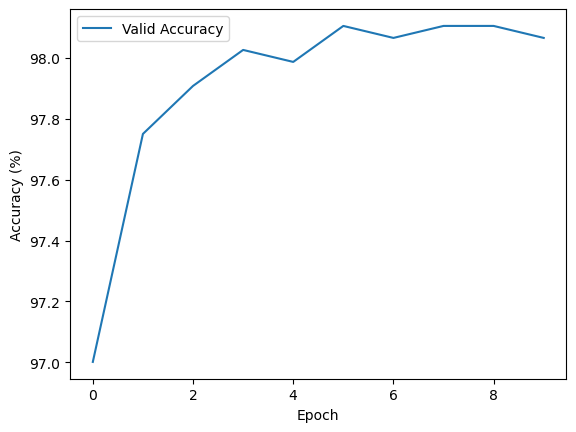

In [20]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [21]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [22]:
best_model_path = 'saved_models/best_model.pth'

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
classifier = nn.Linear(model.config.hidden_size, 25)
model.classifier = classifier

model.load_state_dict(torch.load(best_model_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 손실 함수 및 최적화 기법 설정
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3.1489116479568635e-05)

# 테스트 데이터셋을 이용한 성능 평가
model.eval()

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs.logits, labels).item()
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.0000, Test Accuracy: 97.84%


In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        # 데이터셋 초기화 및 전처리 작업 수행
        self.data = data
        self.transform = transform

    def __len__(self):
        # 데이터셋의 샘플 수 반환
        return len(self.data)

    def __getitem__(self, idx):
        # 인덱스(idx)에 해당하는 샘플 반환
        image = Image.open(self.data['img_path'][idx])

        if self.transform:
            image = self.transform(image)
        
        return image

In [ ]:
real_test_df = pd.read_csv('test.csv')
real_test_dataset = TestDataset(real_test_df, transform=transform)
real_test_loader = DataLoader(real_test_dataset, batch_size=64, shuffle=False)

best_model_path = 'saved_models/best_model_98.06629834254143.pth'
model.load_state_dict(torch.load(best_model_path))
model.eval()

predictions = []

with torch.no_grad():
    for images in real_test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.logits, 1)
        predictions.extend(predicted.cpu().numpy())

# 예측 결과를 label_to_index로 변환하여 DataFrame에 추가합니다.
real_test_df['label'] = predictions
real_test_df['label'] = real_test_df['label'].map({v: k for k, v in label_to_index.items()})
real_test_df['label'].fillna(real_test_df['label'].mode()[0], inplace=True)
real_test_df.to_csv('submission.csv', index=False, columns=['id', 'label'])